In [1]:
!git clone https://github.com/epfml/ML_course/

Cloning into 'ML_course'...
remote: Enumerating objects: 2570, done.
remote: Counting objects: 100% (125/125), done.
remote: Compressing objects: 100% (62/62), done.
remote: Total 2570 (delta 81), reused 69 (delta 63), pack-reused 2445 (from 4)
Receiving objects: 100% (2570/2570), 1.09 GiB | 32.59 MiB/s, done.
Resolving deltas: 100% (1078/1078), done.
Updating files: 100% (181/181), done.


In [23]:
pip install matplotlib==3.7.3 --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
plotnine 0.14.5 requires matplotlib>=3.8.0, but you have matplotlib 3.7.3 which is incompatible.
arviz 0.22.0 requires matplotlib>=3.8, but you have matplotlib 3.7.3 which is incompatible.


In [ ]:
import os
os.kill(os.getpid(), 9)

In [2]:
%cd /content/ML_course/labs/ex05/template

/content/ML_course/labs/ex05/template


In [3]:
%ls

classification_by_least_square.png
classification_by_logistic_regression_gradient_descent.png
classification_by_logistic_regression_newton_method.png
classification_by_logistic_regression_penalized_gradient_descent.png
ex05.ipynb
height_weight_genders.csv
helpers.py
least_squares.py
plots.py
test_utils.py


In [3]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt


# Load test module for sanity check
from test_utils import test

# Logistic Regression
## Classification Using Linear Regression
Load your data.

In [4]:
from helpers import sample_data, load_data, standardize

# load data.
height, weight, gender = load_data()

# build sampled x and y.
seed = 1
y = np.expand_dims(gender, axis=1)
X = np.c_[height.reshape(-1), weight.reshape(-1)]
y, X = sample_data(y, X, seed, size_samples=200)
x, mean_x, std_x = standardize(X)

Use `least_squares` to compute w, and visualize the results.

In [5]:
def least_squares_(y, tx):
    """Calculate the least squares solution."""
    # Calcula w* = (XᵀX)⁻¹ Xᵀy
    w = np.linalg.solve(tx.T @ tx, tx.T @ y)
    # Calcula el error (MSE)
    e = y - tx @ w
    mse = (e @ e) / (2 * len(y))
    return mse, w

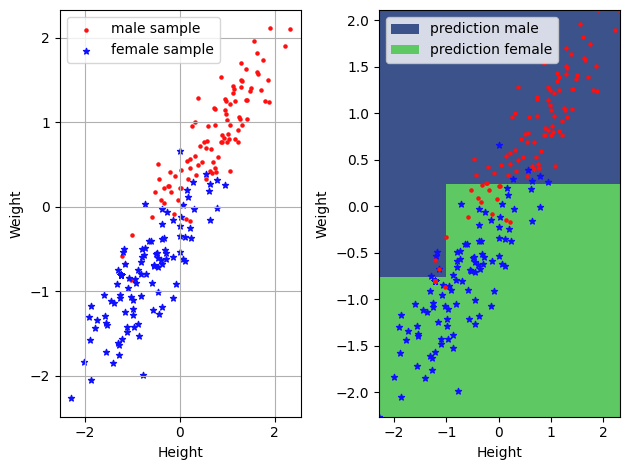

In [6]:
import numpy as np
from plots import visualization

def least_squares_(y, tx):
    """Calculate the least squares solution."""
    y = y.reshape(-1)
    w = np.linalg.solve(tx.T @ tx, tx.T @ y)
    e = y - tx @ w
    mse = (e @ e) / (2 * len(y))
    return mse, w


def least_square_classification_demo(y, x):
    """Least square demo"""
    # Costruisci la matrice di feature con bias
    tx = np.c_[np.ones((y.shape[0], 1)), x]

    # Calcola media e deviazione standard per la normalizzazione nel plot
    mean_x = np.mean(x, axis=0)
    std_x = np.std(x, axis=0)

    # Spacchetta correttamente il risultato
    mse, w = least_squares_(y, tx)

    # Visualizza
    visualization(y, x, mean_x, std_x, w, "classification_by_least_square")


# Esegui la demo
least_square_classification_demo(y, x)

#### The `least_square_classification_demo` is expected to show

![1](https://github.com/epfml/ML_course/blob/main/labs/ex05/template/classification_by_least_square.png?raw=1)

## Logistic Regression

Compute your cost by negative log likelihood.

In [7]:
def sigmoid(t):
    """apply sigmoid function on t.

    Args:
        t: scalar or numpy array

    Returns:
        scalar or numpy array

    >>> sigmoid(np.array([0.1]))
    array([0.52497919])
    >>> sigmoid(np.array([0.1, 0.1]))
    array([0.52497919, 0.52497919])
    """
    base = 1 + np.exp(-t)
    return np.power(base,-1)


test(sigmoid)

✅ Your `sigmoid` passed 2 tests.


In [43]:
def calculate_loss(y, tx, w):
    """compute the cost by negative log likelihood.

    Args:
        y:  shape=(N, 1)
        tx: shape=(N, D)
        w:  shape=(D, 1)

    Returns:
        a non-negative loss

    >>> y = np.c_[[0., 1.]]
    >>> tx = np.arange(4).reshape(2, 2)
    >>> w = np.c_[[2., 3.]]
    >>> round(calculate_loss(y, tx, w), 8)
    1.52429481
    """
    assert y.shape[0] == tx.shape[0]
    assert tx.shape[1] == w.shape[0]
    N = len(y)

    predictions = sigmoid(tx @ w)
    loss = -(1 / len(y)) * (
        y.T @ np.log(predictions) + (1 - y).T @ np.log(1 - predictions)
    )
    return float(loss)


test(calculate_loss)

✅ Your `calculate_loss` passed 4 tests.


/tmp/ipython-input-2076619509.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(loss)


In [24]:
def calculate_gradient(y, tx, w):
    """compute the gradient of loss.

    Args:
        y:  shape=(N, 1)
        tx: shape=(N, D)
        w:  shape=(D, 1)

    Returns:
        a vector of shape (D, 1)

    >>> np.set_printoptions(8)
    >>> y = np.c_[[0., 1.]]
    >>> tx = np.arange(6).reshape(2, 3)
    >>> w = np.array([[0.1], [0.2], [0.3]])
    >>> calculate_gradient(y, tx, w)
    array([[-0.10370763],
           [ 0.2067104 ],
           [ 0.51712843]])
    """


    predictions = sigmoid(tx @ w)
    grad = (tx.T @ (predictions - y)) / len(y)
    return grad


test(calculate_gradient)

✅ Your `calculate_gradient` passed 5 tests.


### Using Gradient Descent
Implement your function to calculate the gradient for logistic regression.

In [31]:
def learning_by_gradient_descent(y, tx, w, gamma):
    """
    Do one step of gradient descent using logistic regression. Return the loss and the updated w.

    Args:
        y:  shape=(N, 1)
        tx: shape=(N, D)
        w:  shape=(D, 1)
        gamma: float

    Returns:
        loss: scalar number
        w: shape=(D, 1)

    >>> y = np.c_[[0., 1.]]
    >>> tx = np.arange(6).reshape(2, 3)
    >>> w = np.array([[0.1], [0.2], [0.3]])
    >>> gamma = 0.1
    >>> loss, w = learning_by_gradient_descent(y, tx, w, gamma)
    >>> round(loss, 8)
    0.62137268
    >>> w
    array([[0.11037076],
           [0.17932896],
           [0.24828716]])
    """
    loss = calculate_loss(y, tx, w)
    grad = calculate_gradient(y, tx, w)
    w_new = w - gamma * grad

    return loss, w_new



test(learning_by_gradient_descent)

✅ Your `learning_by_gradient_descent` passed 7 tests.


/tmp/ipython-input-1698415745.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(loss)


Demo!

/tmp/ipython-input-1698415745.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(loss)


Current iteration=0, loss=0.6931471805599453
Current iteration=100, loss=0.25727807758229915
Current iteration=200, loss=0.2354612766230435
Current iteration=300, loss=0.22402749546644216
Current iteration=400, loss=0.217439348921451
Current iteration=500, loss=0.21337866206030548
Current iteration=600, loss=0.21074981111571245
Current iteration=700, loss=0.2089845098624057
Current iteration=800, loss=0.20776551243295827
Current iteration=900, loss=0.20690519298954663
Current iteration=1000, loss=0.20628738195411772
Current iteration=1100, loss=0.20583744941158433
Current iteration=1200, loss=0.20550598727687253
Current iteration=1300, loss=0.20525946348042878
Current iteration=1400, loss=0.20507464518877044
Current iteration=1500, loss=0.20493515330970438
Current iteration=1600, loss=0.20482926953052655
Current iteration=1700, loss=0.2047485043640546
Current iteration=1800, loss=0.2046866411426354
Current iteration=1900, loss=0.2046390853160284
Current iteration=2000, loss=0.204602414

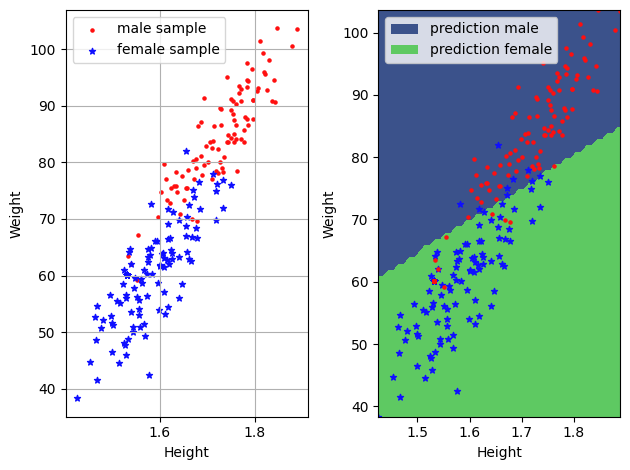

In [32]:
from helpers import de_standardize


def logistic_regression_gradient_descent_demo(y, x):
    # init parameters
    max_iter = 10000
    threshold = 1e-8
    gamma = 0.5
    losses = []

    # build tx
    tx = np.c_[np.ones((y.shape[0], 1)), x]
    w = np.zeros((tx.shape[1], 1))

    # start the logistic regression
    for iter in range(max_iter):
        # get loss and update w.
        loss, w = learning_by_gradient_descent(y, tx, w, gamma)
        # log info
        if iter % 100 == 0:
            print("Current iteration={i}, loss={l}".format(i=iter, l=loss))
        # converge criterion
        losses.append(loss)
        if len(losses) > 1 and np.abs(losses[-1] - losses[-2]) < threshold:
            break
    # visualization
    visualization(
        y,
        x,
        mean_x,
        std_x,
        w,
        "classification_by_logistic_regression_gradient_descent",
        True,
    )
    print("loss={l}".format(l=calculate_loss(y, tx, w)))


logistic_regression_gradient_descent_demo(y, x)

#### The `logistic_regression_gradient_descent_demo` is expected to show

![1](https://github.com/epfml/ML_course/blob/main/labs/ex05/template/classification_by_logistic_regression_gradient_descent.png?raw=1)

Calculate your hessian below

In [45]:
def calculate_hessian(y, tx, w):
    """return the Hessian of the loss function.

    Args:
        y:  shape=(N, 1)
        tx: shape=(N, D)
        w:  shape=(D, 1)

    Returns:
        a hessian matrix of shape=(D, D)

    >>> y = np.c_[[0., 1.]]
    >>> tx = np.arange(6).reshape(2, 3)
    >>> w = np.array([[0.1], [0.2], [0.3]])
    >>> calculate_hessian(y, tx, w)
    array([[0.28961235, 0.3861498 , 0.48268724],
           [0.3861498 , 0.62182124, 0.85749269],
           [0.48268724, 0.85749269, 1.23229813]])
    """
    # ***************************************************
    # INSERT YOUR CODE HERE
    # calculate Hessian: TODO
    # ***************************************************
    N = len(y)
    predictions = sigmoid(tx @ w)
    S = np.diag((predictions * (1 - predictions)).flatten())
    H = (tx.T @ S @ tx) / N
    return H


test(calculate_hessian)

✅ Your `calculate_hessian` passed 4 tests.


Write a function below to return loss, gradient, and hessian.

In [37]:
def logistic_regression(y, tx, w):
    """return the loss, gradient of the loss, and hessian of the loss.

    Args:
        y:  shape=(N, 1)
        tx: shape=(N, D)
        w:  shape=(D, 1)

    Returns:
        loss: scalar number
        gradient: shape=(D, 1)
        hessian: shape=(D, D)

    >>> y = np.c_[[0., 1.]]
    >>> tx = np.arange(6).reshape(2, 3)
    >>> w = np.array([[0.1], [0.2], [0.3]])
    >>> loss, gradient, hessian = logistic_regression(y, tx, w)
    >>> round(loss, 8)
    0.62137268
    >>> gradient, hessian
    (array([[-0.10370763],
           [ 0.2067104 ],
           [ 0.51712843]]), array([[0.28961235, 0.3861498 , 0.48268724],
           [0.3861498 , 0.62182124, 0.85749269],
           [0.48268724, 0.85749269, 1.23229813]]))
    """
    loss = calculate_loss(y, tx, w)
    grad = calculate_gradient(y, tx, w)
    hess = calculate_hessian(y, tx, w)

    return loss, grad, hess


test(logistic_regression)

✅ Your `logistic_regression` passed 6 tests.


/tmp/ipython-input-1698415745.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(loss)


### Using Newton's method
Use Newton's method for logistic regression.

In [41]:
def learning_by_newton_method(y, tx, w, gamma):
    """
    Do one step of Newton's method.
    Return the loss and updated w.

    Args:
        y:  shape=(N, 1)
        tx: shape=(N, D)
        w:  shape=(D, 1)
        gamma: scalar

    Returns:
        loss: scalar number
        w: shape=(D, 1)

    >>> y = np.c_[[0., 0., 1., 1.]]
    >>> np.random.seed(0)
    >>> tx = np.random.rand(4, 3)
    >>> w = np.array([[0.1], [0.5], [0.5]])
    >>> gamma = 0.1
    >>> loss, w = learning_by_newton_method(y, tx, w, gamma)
    >>> round(loss, 8)
    0.71692036
    >>> w
    array([[-1.31876014],
           [ 1.0590277 ],
           [ 0.80091466]])
    """
    loss, grad, hess = logistic_regression(y, tx, w)
    delta_w = np.linalg.solve(hess, grad)
    w -= gamma* delta_w
    return loss, w


test(learning_by_newton_method)

✅ Your `learning_by_newton_method` passed 8 tests.


/tmp/ipython-input-1698415745.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(loss)


demo

/tmp/ipython-input-1698415745.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(loss)


Current iteration=0, the loss=0.6931471805599453
Current iteration=1, the loss=0.31705776869547975
Current iteration=2, the loss=0.23652293099675326
Current iteration=3, the loss=0.20998733711242246
Current iteration=4, the loss=0.2047819931861897
Current iteration=5, the loss=0.20447559968244788
Current iteration=6, the loss=0.20447412808813537
Current iteration=7, the loss=0.20447412804945295
loss=0.20447412804945286


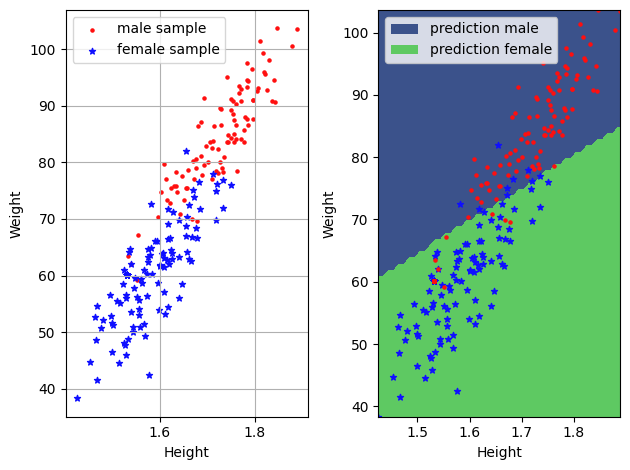

In [42]:
def logistic_regression_newton_method_demo(y, x):
    # init parameters
    max_iter = 100
    threshold = 1e-8
    lambda_ = 0.1
    gamma = 1.0
    losses = []

    # build tx
    tx = np.c_[np.ones((y.shape[0], 1)), x]
    w = np.zeros((tx.shape[1], 1))

    # start the logistic regression
    for iter in range(max_iter):
        # get loss and update w.
        loss, w = learning_by_newton_method(y, tx, w, gamma)
        # log info
        if iter % 1 == 0:
            print("Current iteration={i}, the loss={l}".format(i=iter, l=loss))

        # converge criterion
        losses.append(loss)
        if len(losses) > 1 and np.abs(losses[-1] - losses[-2]) < threshold:
            break
    # visualization
    visualization(
        y,
        x,
        mean_x,
        std_x,
        w,
        "classification_by_logistic_regression_newton_method",
        True,
    )
    print("loss={l}".format(l=calculate_loss(y, tx, w)))


logistic_regression_newton_method_demo(y, x)

#### The `logistic_regression_newton_method_demo` is expected to show

![1](https://github.com/epfml/ML_course/blob/main/labs/ex05/template/classification_by_logistic_regression_newton_method.png?raw=1)

### Using penalized logistic regression
Fill in the function below.

In [57]:
def penalized_logistic_regression(y, tx, w, lambda_):
    """return the loss and gradient.

    Args:
        y:  shape=(N, 1)
        tx: shape=(N, D)
        w:  shape=(D, 1)
        lambda_: scalar

    Returns:
        loss: scalar number
        gradient: shape=(D, 1)

    >>> y = np.c_[[0., 1.]]
    >>> tx = np.arange(6).reshape(2, 3)
    >>> w = np.array([[0.1], [0.2], [0.3]])
    >>> lambda_ = 0.1
    >>> loss, gradient = penalized_logistic_regression(y, tx, w, lambda_)
    >>> round(loss, 8)
    0.62137268
    >>> gradient
    array([[-0.08370763],
           [ 0.2467104 ],
           [ 0.57712843]])
    """
    N = len(y)


    loss = calculate_loss(y,tx,w)

    # 4️⃣ Calcola il gradiente totale
    grad = calculate_gradient(y,tx,w) + 2*(lambda_) * w

    # 5️⃣ Ritorna loss scalare e gradiente colonna
    return float(loss), grad



test(penalized_logistic_regression)

✅ Your `penalized_logistic_regression` passed 7 tests.


/tmp/ipython-input-2076619509.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(loss)


In [60]:
def learning_by_penalized_gradient(y, tx, w, gamma, lambda_):
    """
    Do one step of gradient descent, using the penalized logistic regression.
    Return the loss and updated w.

    Args:
        y:  shape=(N, 1)
        tx: shape=(N, D)
        w:  shape=(D, 1)
        gamma: scalar
        lambda_: scalar

    Returns:
        loss: scalar number
        w: shape=(D, 1)

    >>> np.set_printoptions(8)
    >>> y = np.c_[[0., 1.]]
    >>> tx = np.arange(6).reshape(2, 3)
    >>> w = np.array([[0.1], [0.2], [0.3]])
    >>> lambda_ = 0.1
    >>> gamma = 0.1
    >>> loss, w = learning_by_penalized_gradient(y, tx, w, gamma, lambda_)
    >>> round(loss, 8)
    0.62137268
    >>> w
    array([[0.10837076],
           [0.17532896],
           [0.24228716]])
    """
    loss, grad = penalized_logistic_regression(y, tx, w, lambda_=lambda_)
    w -= gamma*grad
    return loss, w


test(learning_by_penalized_gradient)

✅ Your `learning_by_penalized_gradient` passed 9 tests.


/tmp/ipython-input-2076619509.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(loss)


/tmp/ipython-input-2076619509.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(loss)


Current iteration=0, loss=0.6931471805599453
Current iteration=100, loss=0.2583533620631313
Current iteration=200, loss=0.23768541265662854
Current iteration=300, loss=0.22712668322710844
Current iteration=400, loss=0.22111841388785078
Current iteration=500, loss=0.2174333178698857
Current iteration=600, loss=0.2150446551793466
Current iteration=700, loss=0.21343008764925422
Current iteration=800, loss=0.21230281349464403
Current iteration=900, loss=0.21149551766400648
Current iteration=1000, loss=0.2109056534759823
Current iteration=1100, loss=0.21046773835439975
Current iteration=1200, loss=0.2101384845683434
Current iteration=1300, loss=0.20988842069910987
Current iteration=1400, loss=0.20969697074851962
Current iteration=1500, loss=0.2095494580108115
Current iteration=1600, loss=0.20943522174621151
Current iteration=1700, loss=0.20934639893305246
Current iteration=1800, loss=0.2092771154797812
Current iteration=1900, loss=0.2092229364207028
Current iteration=2000, loss=0.2091804840

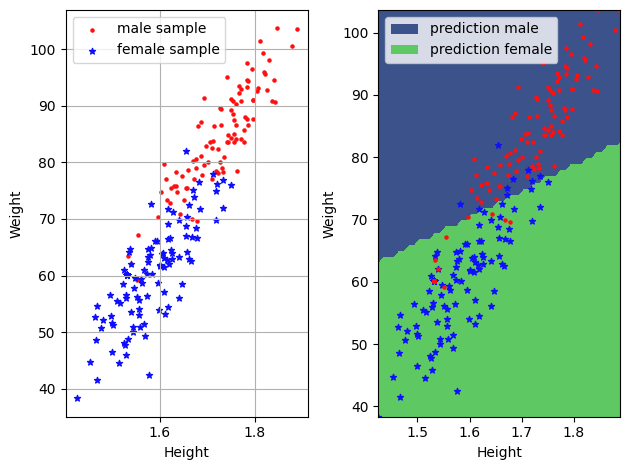

In [61]:
def logistic_regression_penalized_gradient_descent_demo(y, x):
    # init parameters
    max_iter = 10000
    gamma = 0.5
    lambda_ = 0.0005
    threshold = 1e-8
    losses = []

    # build tx
    tx = np.c_[np.ones((y.shape[0], 1)), x]
    w = np.zeros((tx.shape[1], 1))

    # start the logistic regression
    for iter in range(max_iter):
        # get loss and update w.
        loss, w = learning_by_penalized_gradient(y, tx, w, gamma, lambda_)
        # log info
        if iter % 100 == 0:
            print("Current iteration={i}, loss={l}".format(i=iter, l=loss))
        # converge criterion
        losses.append(loss)
        if len(losses) > 1 and np.abs(losses[-1] - losses[-2]) < threshold:
            break
    # visualization
    visualization(
        y,
        x,
        mean_x,
        std_x,
        w,
        "classification_by_logistic_regression_penalized_gradient_descent",
        True,
    )
    print("loss={l}".format(l=calculate_loss(y, tx, w)))


logistic_regression_penalized_gradient_descent_demo(y, x)

#### The `logistic_regression_penalized_gradient_descent_demo` is expected to show

![1](https://github.com/epfml/ML_course/blob/main/labs/ex05/template/classification_by_logistic_regression_penalized_gradient_descent.png?raw=1)